In [55]:
import numpy as np
# import matplotlib as plt
import PIL.Image as img
from pathlib import Path
import matplotlib.pyplot as plt
working_dir = Path().resolve()
print(working_dir)

C:\Users\Vexrina\Desktop\projects\neuron_labs


In [56]:
def show_mtx(mtx):
    plt.imshow(mtx, cmap='gray')
    plt.show()

In [57]:
class Neuron:
    def __init__(
            self, name:str, 
            thetta: float = np.random.uniform(low=0.05, high=1),
            speed: float = np.random.uniform(low=0.05, high=1)
    ):
        '''
        инициализация класса
        Веса в диапазоне -0.03 до 0.03, матрица размером 4х1024
        имя - какая буква пришла на вход
        эпохи - эпохи
        ответы - входные вектора ответов
        скорость - рандомное число в диапазоне между 0.05 до 1.
        '''
        self.weights = np.random.uniform(low=-0.0003, high=0.0003, size=(32,32))
        self.name = name
        self.speed = speed
        self.thetta = thetta

    def activation(self, sum):
        return sum>=self.thetta

    def learn(self, mtx, realname):
        summary = np.sum(self.weights.dot(mtx))
        activate = self.activation(summary)
        if activate and self.name != realname:
            self.weights -= np.dot(self.speed, mtx) # error 0-1=-1
        elif not activate and self.name == realname:
            self.weights += np.dot(self.speed, mtx) # error 1-0=+1
        # if error 1-1=0 (want 1, result 1) we cant create new weights, bc error = 0, so
        # secont multi = speed*0*weight = 0.
    
    def testing(self, mtx):
        summary = np.sum(self.weights.dot(mtx))
        if self.activation(summary):
            return True
        else:
            return False
        
    '''
    TODO:
    Тренировка по эпохам
    Тренировка по результатам
    Тренировка по весам
    '''

In [58]:
class Network():
    def __init__(
            self,
            speed: float = np.random.uniform(low=0.05, high=1),
            thetta: float = np.random.uniform(low=0.05, high=1),
            epoch: int = 50
    ):
        self.letters = ['q', 'h', 'i', 'w']
        self.letters_data = []
        self.mtxs = []
        self.take_datas()
        for data in self.letters_data:
            self.mtxs.append(self.tuples_to_mtx(data))
        self.epoch = epoch
        self.neurons = [Neuron(letter, thetta=thetta, speed=speed)
                        for letter in self.letters]
        print(f'Настройки:\nКол-во эпох - {epoch}\nСкорость - {speed}')

    def take_datas(self):
        '''
        Перевод всех изображений в матрицу и сохранений всех матриц в отдельный массив
        '''
        for letter in self.letters:
            for i in range(4):  # 4 - количество образов буквы
                file_name = f'letters/{letter}{i+1}.png'
                image = img.open(working_dir/file_name)
                data = image.convert('RGBA').getdata()
                self.letters_data.append(data)

    def tuples_to_mtx(self, data):
        '''
        Конвентирует массив тюплов в матрицу, 
        где ТОЛЬКО черный цвет с alpha=255 - единица,
        а любое другое значение - 0
        '''
        result = [[]]
        i, j = 0, 0
        for item in data:
            if j == 32:
                result.append([])
                i += 1
                j = 0
            if item[0] == 0 and item[1] == 0 and item[2] == 0 and item[3] == 255:
                result[i].append(1)
                j += 1
            else:
                result[i].append(0)
                j += 1
        return result

    def show_weights(self):
        for i, l in enumerate(self.letters):
            print(f'Neuron {l}:')
            plt.imshow(self.neurons[i].weights, cmap='gray')
            plt.show()

    def train(self):
        for __ in range(self.epoch):
            # q
            for index in range(4):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[0])
                    # print('was here')
            # h
            for index in range(4, 8):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[1])
            # i
            for index in range(8, 12):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[2])
            # w
            for index in range(12, 16):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[3])

    def test(self):
        datas = []
        for letter in self.letters:
            file_name = f'letters/{letter}_test.png'
            image = img.open(working_dir/file_name)
            datas.append(image.convert('RGBA').getdata())
            
        self.test_pic = []
        for data in datas:
            result = [[]]
            i, j = 0, 0
            for item in data:
                if j == 32:
                    result.append([])
                    i += 1
                    j = 0
                if item[0] == 0 and item[1] == 0 and item[2] == 0 and item[3] == 255:
                    result[i].append(1)
                    j += 1
                else:
                    result[i].append(0)
                    j += 1
            self.test_pic.append(result)
        
        k = 0
        for pic in self.test_pic:
            print(f'THIS WAS A {self.letters[k]}')
            print('Network result:')
            for neuron in self.neurons:
                if neuron.testing(pic):
                    print(f'This is {neuron.name}')
                else:
                    print(f'This isnot {neuron.name}')
            print()
            k+=1


In [59]:
network = Network(0.5, 0.5, 50)
# print(f'{len(network.mtxs[0][0])}x{len(network.mtxs[0])}')
# print(f'{len(network.neurons[0].weights[0])}x{len(network.neurons[0].weights)}')

Настройки:
Кол-во эпох - 50
Скорость - 0.5


Neuron q:


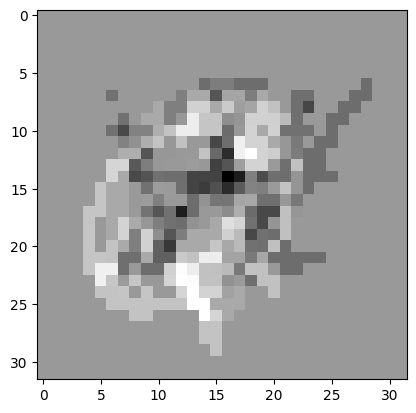

Neuron h:


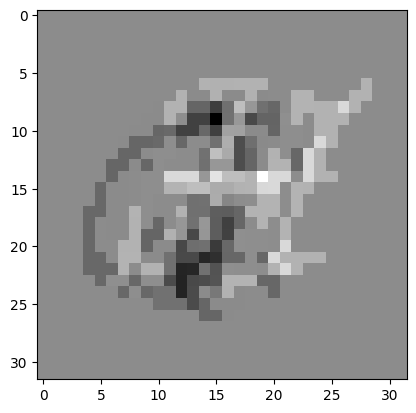

Neuron i:


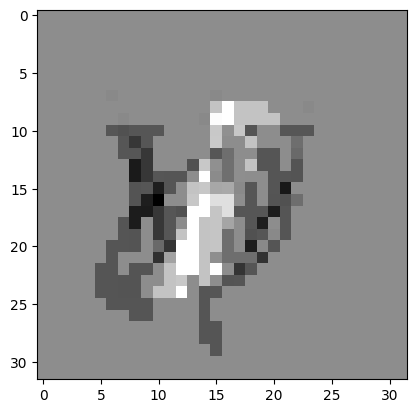

Neuron w:


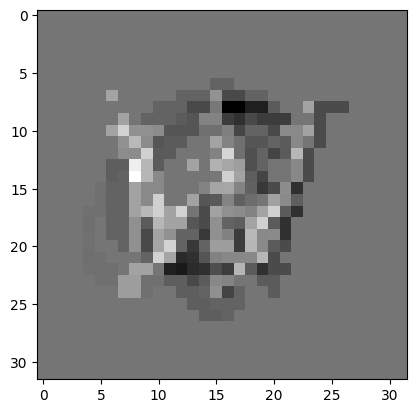

In [60]:
network.train()
network.show_weights()

In [61]:
network.test()

4
THIS WAS A q
Network result:
This isnot q
This is h
This isnot i
This isnot w

THIS WAS A h
Network result:
This isnot q
This is h
This isnot i
This isnot w

THIS WAS A i
Network result:
This isnot q
This isnot h
This is i
This isnot w

THIS WAS A w
Network result:
This isnot q
This isnot h
This isnot i
This isnot w

